<a href="https://colab.research.google.com/github/antonior92/advtrain-linreg/blob/main/notebooks/fig2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy.random as rnd
import cvxpy as cp
import matplotlib.pyplot as plt


def get_max_alpha(X, y, q=2):
    n, m = X.shape
    var = cp.Variable(n)

    obj = cp.Maximize(var @ y)
    constr = [cp.pnorm(X.T @ var, q) <= 1,]
    prob = cp.Problem(obj, constr)
    result = prob.solve()
    return 1 / (n * np.max(np.abs(var.value)))

n_rep = 5
max_range = 2
n_features = 20
n_train = 60
parameter_norm=1
noise_std = 1

# Generate dataset
def get_dataset(i):
  rng = np.random.RandomState(i)
  beta = parameter_norm / np.sqrt(n_features) * rng.randn(n_features)
  X = rng.randn(n_train, n_features)
  # Generate output with random additive noise
  e = rng.randn(n_train)
  y = X @ beta + noise_std * e
  return X, y

all_proportions = np.logspace(0.2, 2, 30)

l2_threshold = np.zeros((n_points * n_rep), dtype=np.float64)
linf_threshold = np.zeros((n_points * n_rep), dtype=np.float64)
l2_inpnorm = np.zeros((n_points * n_rep), dtype=np.float64)
linf_inpnorm = np.zeros((n_points * n_rep), dtype=np.float64)
props  = np.zeros((n_points * n_rep), dtype=np.float64)
index = 0
for prop in tqdm(all_proportions):
    for i in range(n_rep):
        n_features = int(prop * n_train)
        X, y = get_dataset(i)
        # compute thrshold interpolators
        # Evaluate
        props[index] = prop
        l2_threshold[index] = get_max_alpha(X, y, 2)
        linf_threshold[index] = get_max_alpha(X, y, np.inf)
        l2_inpnorm[index] = np.mean(np.linalg.norm(X, axis=1, ord=2))
        linf_inpnorm[index] = np.mean(np.max(np.abs(X), axis=1))

        index += 1

100%|██████████| 30/30 [01:35<00:00,  3.17s/it]


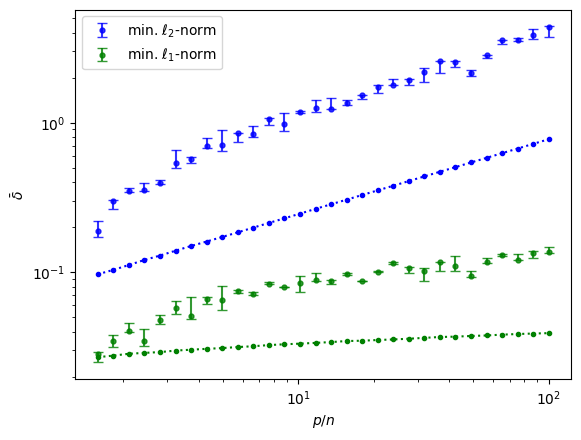

In [34]:
def get_quantiles(xaxis, r, quantileslower=0.25, quantilesupper=0.75):
    new_xaxis, inverse, counts = np.unique(xaxis, return_inverse=True, return_counts=True)

    r_values = np.zeros([len(new_xaxis), max(counts)])
    secondindex = np.zeros(len(new_xaxis), dtype=int)
    for n in range(len(xaxis)):
        i = inverse[n]
        j = secondindex[i]
        r_values[i, j] = r[n]
        secondindex[i] += 1
    m = np.median(r_values, axis=1)
    lerr = m - np.quantile(r_values, quantileslower, axis=1)
    uerr = np.quantile(r_values, quantilesupper, axis=1) - m
    return new_xaxis, m, lerr, uerr


fig, ax = plt.subplots()
# l2 adv attack
new_x, m, lerr, uerr = get_quantiles(props, l2_threshold)
ax.errorbar(new_x, m, yerr=[lerr, uerr], capsize=3.5, alpha=0.8,
                marker='o', markersize=3.5, ls='', label=r'min. $\ell_2$-norm', color='blue')
# Plot reference
xv, yv, _, _ = get_quantiles(props, l2_inpnorm)
plt.plot(xv, 0.01*yv, color='blue', ls=':', marker='.')
# l1 adv attack
new_x, m, lerr, uerr = get_quantiles(props, linf_threshold)
ax.errorbar(new_x, m, yerr=[lerr, uerr], capsize=3.5, alpha=0.8,
                marker='o', markersize=3.5, ls='', label=r'min. $\ell_1$-norm', color='green')
# Plot reference
xv, yv, _, _ = get_quantiles(props, linf_inpnorm)
plt.plot(xv, 0.01*yv, color='green', ls=':', marker='.')
# Extra plot settings
ax.set_xlabel('$p / n$')
ax.set_ylabel(r'$\bar \delta$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()